In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, BatchNormalization, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [3]:
# Step 1: Load and prepare the data
# Replace with your local file path if running locally
file_path = "./dga_data.csv"

dga_data = pd.read_csv(file_path)

# Exploratory Data Analysis (EDA)

In [4]:
# 1. Distribution of 'isDGA' column
isDGA_distribution = dga_data['isDGA'].value_counts()

# 2. Distribution of 'subclass'
subclass_distribution = dga_data['subclass'].value_counts()

# 3. Calculate length of domains and hosts
dga_data['domain_length'] = dga_data['domain'].str.len()
dga_data['host_length'] = dga_data['host'].str.len()

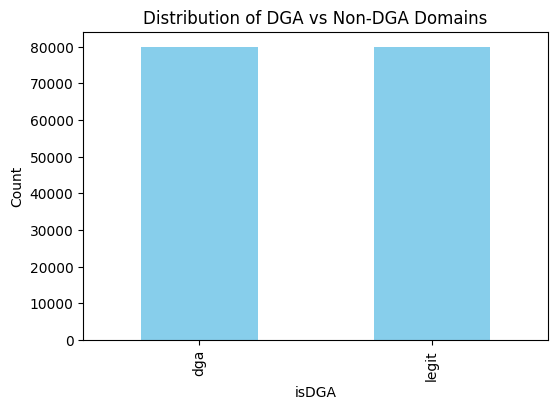

In [5]:
# Plot 1: Distribution of 'isDGA'
plt.figure(figsize=(6, 4))
isDGA_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of DGA vs Non-DGA Domains')
plt.ylabel('Count')
plt.show()

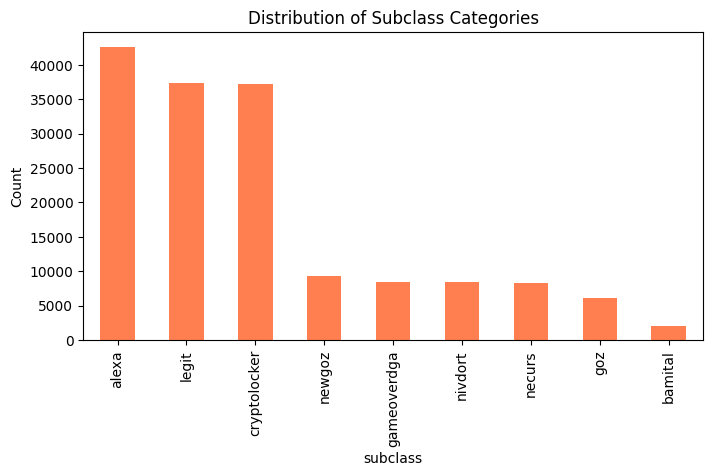

In [6]:
# Plot 2: Distribution of 'subclass'
plt.figure(figsize=(8, 4))
subclass_distribution.plot(kind='bar', color='coral')
plt.title('Distribution of Subclass Categories')
plt.ylabel('Count')
plt.show()

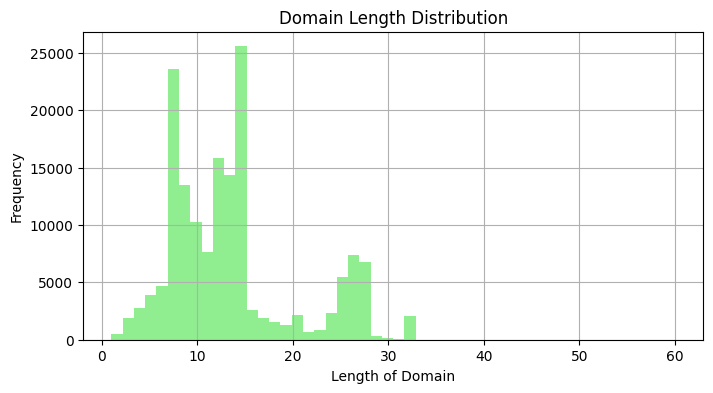

In [7]:
# Plot 3: Domain Length Distribution
plt.figure(figsize=(8, 4))
dga_data['domain_length'].hist(bins=50, color='lightgreen')
plt.title('Domain Length Distribution')
plt.xlabel('Length of Domain')
plt.ylabel('Frequency')
plt.show()

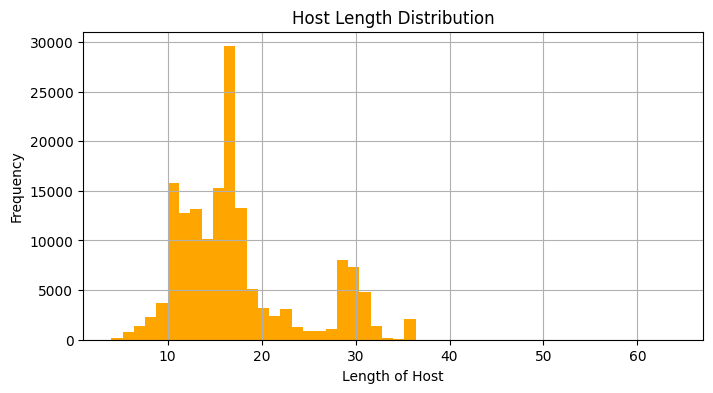

In [8]:
# Plot 4: Host Length Distribution
plt.figure(figsize=(8, 4))
dga_data['host_length'].hist(bins=50, color='orange')
plt.title('Host Length Distribution')
plt.xlabel('Length of Host')
plt.ylabel('Frequency')
plt.show()

In [9]:
# 5. Summary statistics for domain and host lengths
domain_host_summary = dga_data[['domain_length', 'host_length']].describe()
print(domain_host_summary)

       domain_length    host_length
count  159998.000000  160000.000000
mean       13.467462      17.293425
std         6.626097       6.569695
min         1.000000       4.000000
25%         9.000000      13.000000
50%        12.000000      16.000000
75%        15.000000      19.000000
max        60.000000      64.000000


# Data Preprocessing

## Oversampling

In [10]:
# prompt: simplify df to just column domain and subclass

df = dga_data

# Keep only the 'domain' and 'subclass' columns
sliced_df = df[['domain','host', 'subclass']]
original_df = sliced_df.copy()

sliced_df


,domain,host,subclass
0,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,jpqftymiuver,jpqftymiuver.ru,cryptolocker
...,...,...,...
159995,manhunt,manhunt.net,alexa
159996,yupptv,yupptv.com,alexa
159997,bbcmundo,bbcmundo.com,legit
159998,kanogames,kanogames.com,legit


In [11]:
original_df['host'] = original_df['host'].fillna('')
original_df['domain'] = original_df['domain'].fillna('')

sliced_df['domain'] = sliced_df['domain'].fillna('')

<ipython-input-11-1c1ca208b524>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['domain'] = sliced_df['domain'].fillna('')


In [12]:
!pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.6 MB/s eta 0:00:00


In [13]:
import tldextract

sliced_df['host'] = sliced_df['host'].fillna('').astype(str)

# Sample DataFrame
# Extract TLD
sliced_df['tld'] = sliced_df['host'].apply(lambda x: tldextract.extract(x).suffix)

print(sliced_df)

<ipython-input-13-21902db28c1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['host'] = sliced_df['host'].fillna('').astype(str)


                            domain                            host  \
0       6xzxsw3sokvg1tc752y1a6p0af  6xzxsw3sokvg1tc752y1a6p0af.com   
1                   glbtlxwwhbnpxs               glbtlxwwhbnpxs.ru   
2                   xxmamopyipbfpk               xxmamopyipbfpk.ru   
3        zfd5szpi18i85wj9uy13l69rg   zfd5szpi18i85wj9uy13l69rg.net   
4                     jpqftymiuver                 jpqftymiuver.ru   
...                            ...                             ...   
159995                     manhunt                     manhunt.net   
159996                      yupptv                      yupptv.com   
159997                    bbcmundo                    bbcmundo.com   
159998                   kanogames                   kanogames.com   
159999                   roadrover                    roadrover.cn   

            subclass  tld  
0        gameoverdga  com  
1       cryptolocker   ru  
2       cryptolocker   ru  
3             newgoz  net  
4       cryptolocke

<ipython-input-13-21902db28c1a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['tld'] = sliced_df['host'].apply(lambda x: tldextract.extract(x).suffix)


### Data Augmentation

As seen from the subclass frequency, 6 of the 7 DGA subclasses are massively underrepresented. And since *imbalanced* dataset also hurts our model's learning

In [14]:
tld_to_append = {}

for subclass in sliced_df['subclass'].unique():
    curr_tld = sliced_df[sliced_df['subclass']== subclass]['tld'].unique().tolist()
    tld_to_append[subclass] = curr_tld
sliced_df = sliced_df.drop('tld', axis=1)

In [15]:
# prompt: display one example from each subclass in ['gameoverdga',
#  'cryptolocker',
#  'newgoz',
#  'nivdort',
#  'goz',
#  'necurs',
#  'bamital']

target_subclasses = ['gameoverdga', 'cryptolocker', 'newgoz', 'nivdort', 'goz', 'necurs', 'bamital']

for subclass in target_subclasses:
  example_domain = sliced_df[sliced_df['subclass'] == subclass]['host'].iloc[0]
  print(f"Subclass: {subclass}, Example host: {example_domain}")

Subclass: gameoverdga, Example host: 6xzxsw3sokvg1tc752y1a6p0af.com
Subclass: cryptolocker, Example host: glbtlxwwhbnpxs.ru
Subclass: newgoz, Example host: zfd5szpi18i85wj9uy13l69rg.net
Subclass: nivdort, Example host: takenroll.net
Subclass: goz, Example host: rcdqeqmpxgdiuqombhuwcfu.ru
Subclass: necurs, Example host: sfmbdpnijlarq.cc
Subclass: bamital, Example host: 5df9d44072820ad6eaac91669f357fea.org


If we look at the examples of the subclasses above, we chose to do the following possible actions for all the subclasses except **nivdort**:
* swap_character()
* insert_character()
* delete_character()
* substitute_character()

The spirit of this is similar to BART's pretraining methodology: sentence-corruption.

In [16]:
import random
import string

# Higher probabilities for more aggressive augmentations
augment_probs = {
    'swap': 0.4,
    'insert': 0.35,
    'delete': 0.3,
    'substitute': 0.25,
}

# Function to forcefully apply augmentations aggressively
def data_augment(domain, num_augmentations, tld_to_append):
    augmented_domains = set()

    while len(augmented_domains) < num_augmentations:
        augmented_domain = domain
        applied = False  # Track if any augmentation is applied

        # Loop through augmentations and apply each based on probability
        for _ in range(2):  # Apply 2 augmentations per call
            if random.random() < augment_probs['swap']:
                augmented_domain = swap_characters(augmented_domain)
                applied = True

            if random.random() < augment_probs['insert']:
                augmented_domain = insert_character(augmented_domain)
                applied = True

            if random.random() < augment_probs['delete']:
                augmented_domain = delete_character(augmented_domain)
                applied = True

            if random.random() < augment_probs['substitute']:
                augmented_domain = substitute_character(augmented_domain)
                applied = True

        # Ensure at least one augmentation is applied
        random_tld = random.choice(tld_to_append)
        augmented_domain_with_tld = f"{augmented_domain}.{random_tld}"

        augmented_domains.add((augmented_domain, augmented_domain_with_tld))
        # Add to set of unique augmented domains
    return list(augmented_domains)

# Define forced augmentation to ensure at least one augmentation
def force_random_augmentation(domain):
    aug_type = random.choice(['swap', 'insert', 'delete', 'substitute'])
    if aug_type == 'swap':
        return swap_characters(domain)
    elif aug_type == 'insert':
        return insert_character(domain)
    elif aug_type == 'delete':
        return delete_character(domain)
    elif aug_type == 'substitute':
        return substitute_character(domain)

# Swap adjacent characters in the domain
def swap_characters(domain):
    if len(domain) > 1:
        idx = random.randint(0, len(domain) - 2)
        domain_list = list(domain)
        domain_list[idx], domain_list[idx + 1] = domain_list[idx + 1], domain_list[idx]
        return ''.join(domain_list)
    return domain

# Insert a random character at a random position
def insert_character(domain):
    idx = random.randint(0, len(domain) - 1)
    random_char = random.choice(string.ascii_lowercase + string.digits)
    return domain[:idx] + random_char + domain[idx:]

# Delete a random character from the domain
def delete_character(domain):
    if len(domain) > 1:
        idx = random.randint(0, len(domain) - 1)
        return domain[:idx] + domain[idx + 1:]
    return domain

# Substitute a random character in the domain with another
def substitute_character(domain):
    idx = random.randint(0, len(domain) - 1)
    random_char = random.choice(string.ascii_lowercase + string.digits)
    return domain[:idx] + random_char + domain[idx + 1:]


In [17]:
target_subclasses = ['gameoverdga', 'newgoz', 'goz', 'necurs', 'bamital']

# Define the number of augmentations for each subclass
num_augmentations = {subclass: 4 for subclass in target_subclasses}
num_augmentations['bamital'] = 15

# Create a list to hold all new rows
new_rows = []

# Iterate through each subclass and apply data augmentation
for subclass in target_subclasses:
    domains_to_augment = sliced_df[sliced_df['subclass'] == subclass]['domain'].tolist()
    tld = tld_to_append[subclass]
    # Generate augmented domains using list comprehension
    augmented_domains = [
        (augmented_domain, augmented_host)
        for domain in domains_to_augment
        for augmented_domain, augmented_host in data_augment(domain, num_augmentations[subclass],tld)
    ]

    # Prepare new rows for the DataFrame
    new_rows.extend([{'domain': augmented_domain, 'host': augmented_host, 'subclass': subclass} for augmented_domain, augmented_host in augmented_domains])

# Convert the list of new rows to a DataFrame and append it to the original DataFrame
if new_rows:
    new_df = pd.DataFrame(new_rows)
    sliced_df = pd.concat([sliced_df, new_df], ignore_index=True)

In [18]:
sliced_df

,domain,host,subclass
0,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,jpqftymiuver,jpqftymiuver.ru,cryptolocker
...,...,...,...
320101,3fbedce347a7e6e1b40fc124623302090,3fbedce347a7e6e1b40fc124623302090.org,bamital
320102,3fbedec3477a6e01b40fc12463302090,3fbedec3477a6e01b40fc12463302090.org,bamital
320103,3fbedec347a76o1b40fc124623302090,3fbedec347a76o1b40fc124623302090.org,bamital
320104,3fbeme3c47a76e1b40fco124623302090,3fbeme3c47a76e1b40fco124623302090.org,bamital


For **nivdort** specifically, it is quite apparent that it is a composition of two words in a fixed dictionary. and as such, we can augment more datas using these logic

* generate_nivdort()

To do so, we will look at the known domains, use a Language Model to help us identify the words used to build our dictionary. This dictionary then will be used to generate new nivdort samples

In [19]:
!pip install nltk

In [20]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [21]:
from nltk.corpus import words

# Set of valid English words (for validation purposes)
word_set = set(words.words())

# Function to process all rows and store words in a dictionary
def extract_words_from_rows(df, column_name):
    word_dict = {}

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        concatenated_word = row[column_name]
        word1, word2 = split_concatenated_words(concatenated_word,word_set)

        # Add the words to the dictionary and count their occurrences
        if word1 and word2:
            word_dict[word1] = word_dict.get(word1, 0) + 1
            word_dict[word2] = word_dict.get(word2, 0) + 1

    return word_dict

In [22]:
# prompt: using the word_dict, generate new nivdort domains that are not duplicate of the known ones (meaning if word 1 and word 2 is contained in a specific domain, we dont use that pair)
import random
import math

def split_concatenated_words(concatenated_word, word_set):
    """Splits a concatenated word into two valid words based on a word set."""
    for i in range(1, len(concatenated_word)):
        word1, word2 = concatenated_word[:i], concatenated_word[i:]
        if word1 in word_set and word2 in word_set:
            return word1, word2
    return concatenated_word, None

def generate_nivdort_domains(word_dict, known_domains, num_domains=32000, max_attempts=50, overlap_tolerance=0.1):
    """Generates new Nivdort domains with a balanced approach between uniqueness and aggression."""

    word_set = set(word_dict.keys())
    known_word_pairs = {frozenset([split_concatenated_words(domain.split('.')[0], word_set)]) for domain in known_domains}

    # Track newly generated domains and avoid strict overlap with known pairs
    new_domains = []
    i, j = 0, 0

    while i < num_domains and j < max_attempts * num_domains:
        word1 = random.choice(list(word_dict.keys()))
        word2 = random.choice(list(word_dict.keys()))

        # Check the pair uniqueness with some tolerance
        word_pair = frozenset([word1, word2])
        overlap = sum(1 for pair in known_word_pairs if pair == word_pair) / len(known_word_pairs)

        if overlap <= overlap_tolerance:  # Allow slight overlap with known pairs
            domain = word1 + word2

            if domain not in known_domains and domain not in new_domains:
                new_domains.append(domain)
                known_word_pairs.add(word_pair)  # Add to avoid duplicate generation
                i += 1
        j += 1

    return new_domains



In [23]:
known_nivdort_domains = df[df['subclass'] == 'nivdort']['domain'].tolist()
print(known_nivdort_domains)

['takenroll', 'dreamdont', 'visitshot', 'mostjune', 'fairslow', 'triedlady', 'movemarch', 'drinkusual', 'caseought', 'takenshoe', 'dreamfind', 'wifelate', 'gladtell', 'thesethan', 'dreamfine', 'madehear', 'wronghurry', 'knowpeace', 'casegreen', 'threethrow', 'hillgold', 'whichback', 'milkjune', 'quickcloth', 'wrongtear', 'darkthan', 'equalaugust', 'whichcompe', 'wrongoctober', 'songfloor', 'spendwhere', 'hangseven', 'drinkgrow', 'whichsuch', 'thenought', 'wishmarry', 'groupback', 'yardgift', 'dutywrote', 'joinaunt', 'joinrest', 'takenlift', 'caseborn', 'feltgold', 'triedking', 'milksaturday', 'rockhigh', 'takenprice', 'sickpast', 'lookdance', 'joinhope', 'feltboat', 'groupmoon', 'wronghunt', 'withfind', 'spotleft', 'movedish', 'fairunder', 'mademail', 'lordshade', 'equalhigh', 'spendheight', 'humanfind', 'wifemine', 'looksome', 'quickborn', 'arivepull', 'wishgold', 'watchslow', 'dutykind', 'wifepure', 'feltought', 'signhour', 'ariveover', 'songwrote', 'saltworld', 'wifehand', 'darkcons

In [24]:
word_dict = extract_words_from_rows(df[df['subclass'] == 'nivdort'], 'domain')
print(len(list(word_dict.keys())))

368


In [25]:
# Example usage:
new_nivdort_domains = generate_nivdort_domains(word_dict, known_nivdort_domains, num_domains=32000)
# print("New Nivdort Domains:", new_nivdort_domains)

In [26]:
# prompt: send these nivdort_domains to sliced_df
tld = tld_to_append['nivdort']

# Create new rows for the DataFrame
new_nivdort_rows = [{'host': f'{domain}.{random.choice(tld)}','domain': domain, 'subclass': 'nivdort'} for domain in new_nivdort_domains]

# Convert the list of new rows to a DataFrame and append it to the original DataFrame
if new_nivdort_rows:
    new_nivdort_df = pd.DataFrame(new_nivdort_rows)
    sliced_df = pd.concat([sliced_df, new_nivdort_df], ignore_index=True)

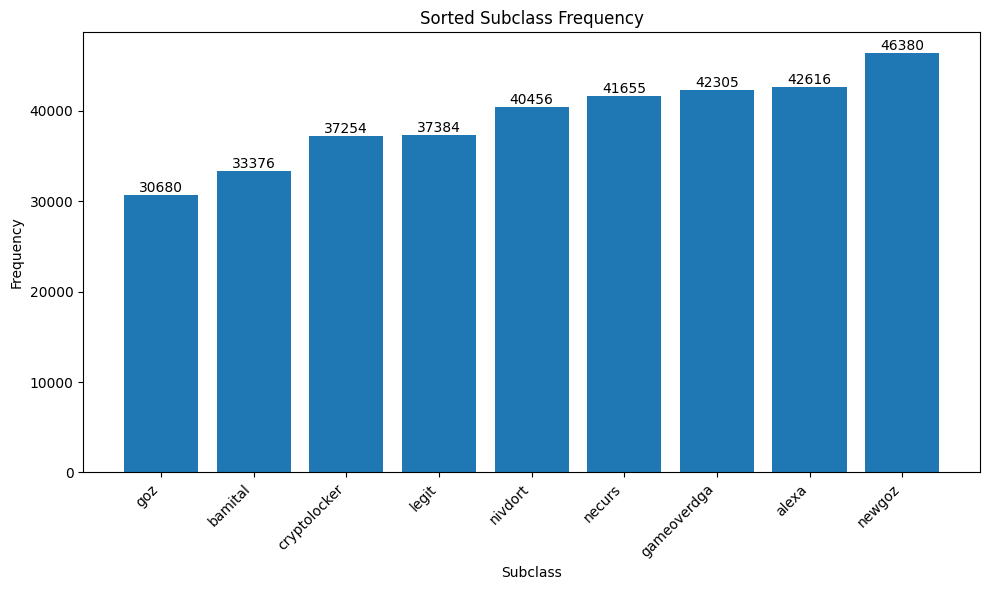

In [27]:
# prompt: visualize the sorted subclass frequency of sliced_df using vertical barchart with each frequency on the bar with 3 significant figures

# Assuming 'sliced_df' is your DataFrame
subclass_counts = sliced_df['subclass'].value_counts().sort_values()

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(subclass_counts.index, subclass_counts.values)

# Add frequency labels to the bars with 3 significant figures
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

plt.xlabel('Subclass')
plt.ylabel('Frequency')
plt.title('Sorted Subclass Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [28]:
sliced_df = sliced_df.sample(frac=1).reset_index(drop=True)
original_df = original_df.sample(frac=1).reset_index(drop=True)

In [29]:
sliced_df

,domain,host,subclass
0,fq6hoj1mn5ce401osyzz3cqk7nw,fq6hoj1mn5ce401osyzz3cqk7nw.com,newgoz
1,1jq797f1jhlz5e1j6trpm1muvi5g,1jq797f1jhlz5e1j6trpm1muvi5g.com,newgoz
2,icfjqlkhflssa,icfjqlkhflssa.ru,cryptolocker
3,19l7z4e1iya4v741yietsoy949we,19l7z4e1iya4v741yietsoy949we.net,gameoverdga
4,hhnfmnadwoudrmqtg,hhnfmnadwoudrmqtg.net,necurs
...,...,...,...
352101,atauntcolor,atauntcolor.net,nivdort
352102,throwhope,throwhope.net,nivdort
352103,gegndhsulpimq,gegndhsulpimq.sh,necurs
352104,aadtlkmottjb,aadtlkmottjb.biz,cryptolocker


In [30]:
original_df

,domain,host,subclass
0,brightsidexdr,brightsidexdr.com,legit
1,eurobank,eurobank.gr,alexa
2,govtrack,govtrack.us,legit
3,lg,lg.com,alexa
4,lolalila,lolalila.com,alexa
...,...,...,...
159995,zvlvnjzlbbisgxgxgmyppjea,zvlvnjzlbbisgxgxgmyppjea.ru,goz
159996,gotlink,gotlink.pl,alexa
159997,cahfrdmq,cahfrdmq.ug,necurs
159998,kbmnskiblibcyrglfwkxhqvwemxw,kbmnskiblibcyrglfwkxhqvwemxw.ru,goz


# Feature Engineering

In [31]:
# Feature Engineering
def extract_features(domain):
    length = len(domain)
    digit_count = sum(c.isdigit() for c in domain)
    special_char_count = sum(not c.isalnum() for c in domain)
    entropy = -sum((domain.count(c) / length) * np.log2(domain.count(c) / length) for c in set(domain))
    return [length, digit_count, special_char_count, entropy]

# Apply the feature extraction function
sliced_df[['length', 'digit_count', 'special_char_count', 'entropy']] = sliced_df['domain'].apply(
    lambda x: pd.Series(extract_features(x)))


# Adding CNN Layer before RNN (Multi-classification)

In [32]:
# Encode subclass labels
sliced_df['subclass_encoded'] = sliced_df['subclass'].astype('category').cat.codes
num_classes = sliced_df['subclass_encoded'].nunique()  # Total number of subclasses

# One-hot encode the subclass labels for multi-class classification
y = to_categorical(sliced_df['subclass_encoded'], num_classes=num_classes)

In [33]:
# Tokenize the domain names for the RNN input
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sliced_df['domain'])

X_sequences = tokenizer.texts_to_sequences(sliced_df['domain'])
max_sequence_length = max(len(seq) for seq in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

# Define the feature matrix for engineered features
X_engineered = sliced_df[['length', 'digit_count', 'special_char_count', 'entropy']].values

In [34]:
# Train-Test Split
X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_padded, X_engineered, y, test_size=0.2, random_state=42
)

In [35]:
# RNN branch with CNN before LSTM
input_seq = Input(shape=(max_sequence_length,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_seq)

# CNN Layer to capture local character patterns
x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = MaxPooling1D()(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Engineered feature branch
input_features = Input(shape=(X_engineered.shape[1],))
y = BatchNormalization()(input_features)
y = Dense(32, activation='relu')(y)

# Concatenate RNN and engineered features
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(num_classes, activation='softmax')(z)

# Compile the model
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 64)         │          2,496 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 56, 64)         │         20,544 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 28, 64)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 28, 128)        │         98,816 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         49,408 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 4)              │             16 │ input_layer_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            160 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          6,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 9)              │            585 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 178,233 (696.22 KB)

 Trainable params: 178,225 (696.19 KB)

 Non-trainable params: 8 (32.00 B)

In [36]:
# Train the Model
history = model.fit(
    [X_seq_train, X_feat_train], y_train,
    validation_split=0.2, epochs=10, batch_size=32, verbose=2
)

Epoch 1/10
7043/7043 - 79s - 11ms/step - accuracy: 0.6704 - loss: 0.6449 - val_accuracy: 0.7163 - val_loss: 0.5161
Epoch 2/10
7043/7043 - 75s - 11ms/step - accuracy: 0.7320 - loss: 0.4938 - val_accuracy: 0.7492 - val_loss: 0.4537
Epoch 3/10
7043/7043 - 69s - 10ms/step - accuracy: 0.7448 - loss: 0.4561 - val_accuracy: 0.7532 - val_loss: 0.4354
Epoch 4/10
7043/7043 - 84s - 12ms/step - accuracy: 0.7491 - loss: 0.4373 - val_accuracy: 0.7527 - val_loss: 0.4326
Epoch 5/10
7043/7043 - 80s - 11ms/step - accuracy: 0.7511 - loss: 0.4275 - val_accuracy: 0.7537 - val_loss: 0.4298
Epoch 6/10
7043/7043 - 81s - 12ms/step - accuracy: 0.7524 - loss: 0.4205 - val_accuracy: 0.7550 - val_loss: 0.4317
Epoch 7/10
7043/7043 - 83s - 12ms/step - accuracy: 0.7557 - loss: 0.4148 - val_accuracy: 0.7415 - val_loss: 0.4233
Epoch 8/10
7043/7043 - 70s - 10ms/step - accuracy: 0.7565 - loss: 0.4087 - val_accuracy: 0.7558 - val_loss: 0.4223
Epoch 9/10
7043/7043 - 84s - 12ms/step - accuracy: 0.7580 - loss: 0.4047 - val_a

In [37]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2201/2201 - 8s - 4ms/step - accuracy: 0.7586 - loss: 0.4153
Test Loss: 0.41528046131134033, Test Accuracy: 0.7586123943328857


In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_true and y_pred contain the true and predicted class labels
y_true = np.argmax(y_test, axis=1)      # True labels in integer form
y_pred = np.argmax(model.predict([X_seq_test, X_feat_test]), axis=1)  # Predicted labels in integer form

# Confusion matrix to see predictions per class
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy and then average them
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)  # Diagonal elements (TP) / sum of each row (actual count per class)
macro_accuracy = per_class_accuracy.mean()

print(f"Macro Accuracy: {macro_accuracy:.2f}")

2201/2201 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Macro Accuracy: 0.77


In [39]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming y_true is the true labels and y_pred_proba is the probability predictions for each class
y_true = np.argmax(y_test, axis=1)  # True labels as class indices
y_pred_proba = model.predict([X_seq_test, X_feat_test])  # Probability predictions for each class

# Calculate multi-class ROC-AUC using OvR
roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (OvR): {roc_auc:.2f}")

2201/2201 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
ROC-AUC (OvR): 0.97


In [40]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming y_true is the true labels and y_pred_proba is the probability predictions for each class
y_true = np.argmax(y_test, axis=1)  # True labels as class indices
y_pred_proba = model.predict([X_seq_test, X_feat_test])  # Probability predictions for each class

# Calculate multi-class ROC-AUC using OvR
roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO): {roc_auc:.2f}")

2201/2201 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
ROC-AUC (OvO): 0.97


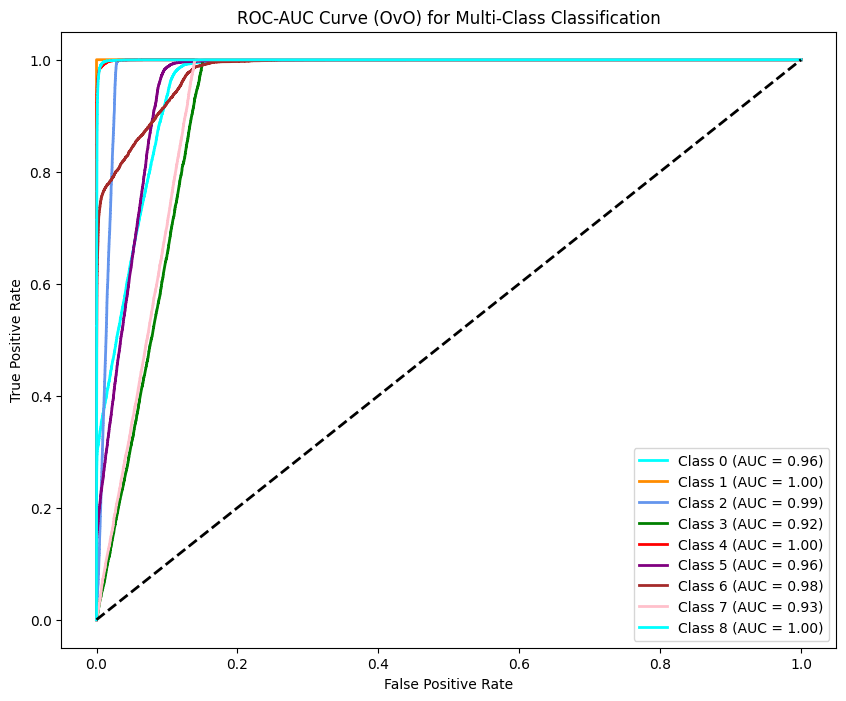

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# Binarize the true labels for each class for OvO calculation
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Plotting parameters
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])

# Compute ROC curve and ROC AUC for each class
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (OvO) for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


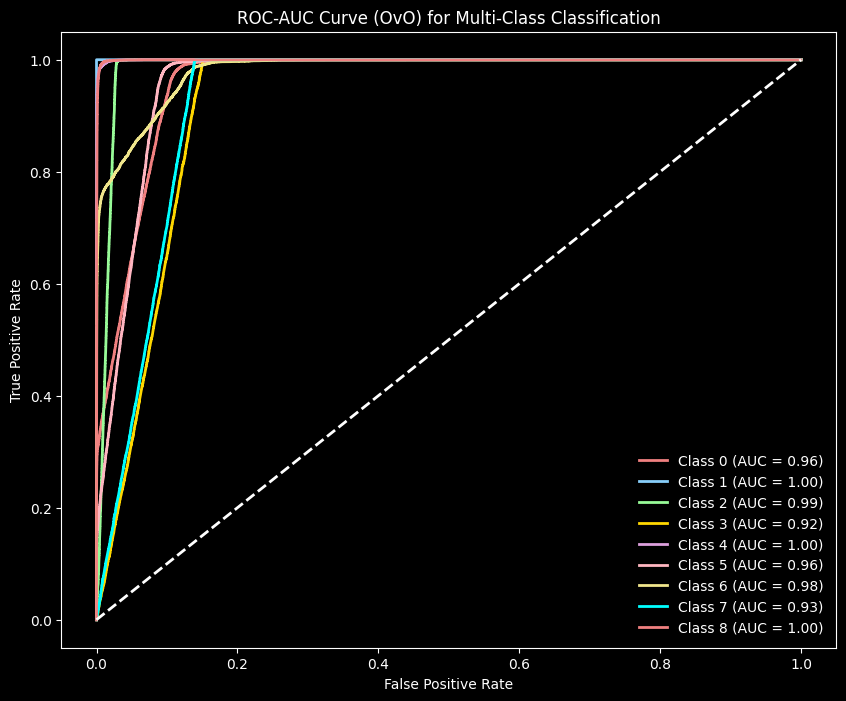

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# Binarize the true labels for each class for OvO calculation
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Set plot style for a dark background
plt.style.use('dark_background')
plt.figure(figsize=(10, 8))

# Colors suitable for dark background
colors = cycle(['lightcoral', 'lightskyblue', 'palegreen', 'gold', 'plum', 'lightpink', 'khaki', 'cyan'])

# Compute ROC curve and ROC AUC for each class
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'w--', lw=2)

# Labels and Title with light color for dark background
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC-AUC Curve (OvO) for Multi-Class Classification', color='white')
plt.legend(loc="lower right", frameon=False)
plt.show()


#

2201/2201 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


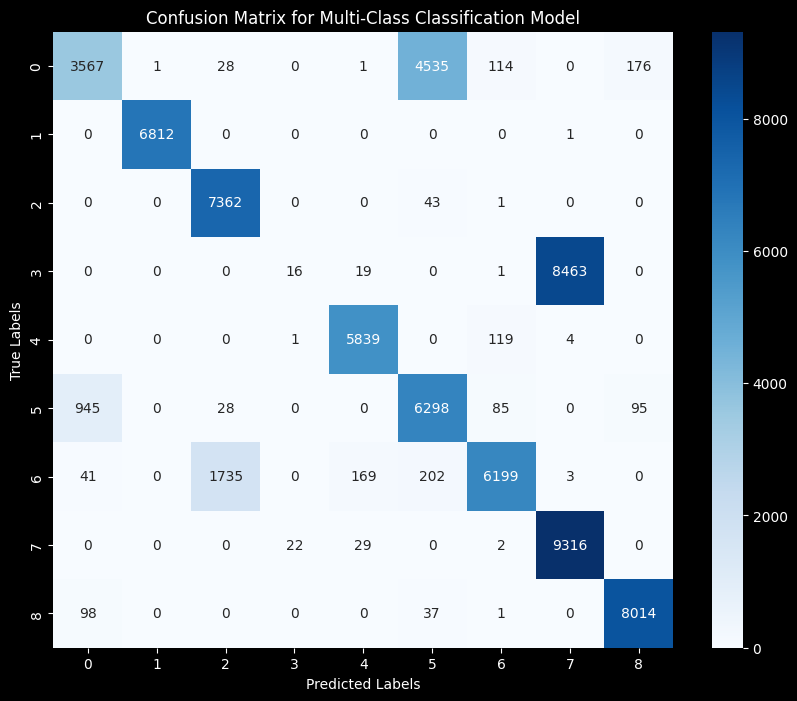

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Convert one-hot encoded labels back to integer format for confusion matrix
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict([X_seq_test, X_feat_test]), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification Model')
plt.show()


2201/2201 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step


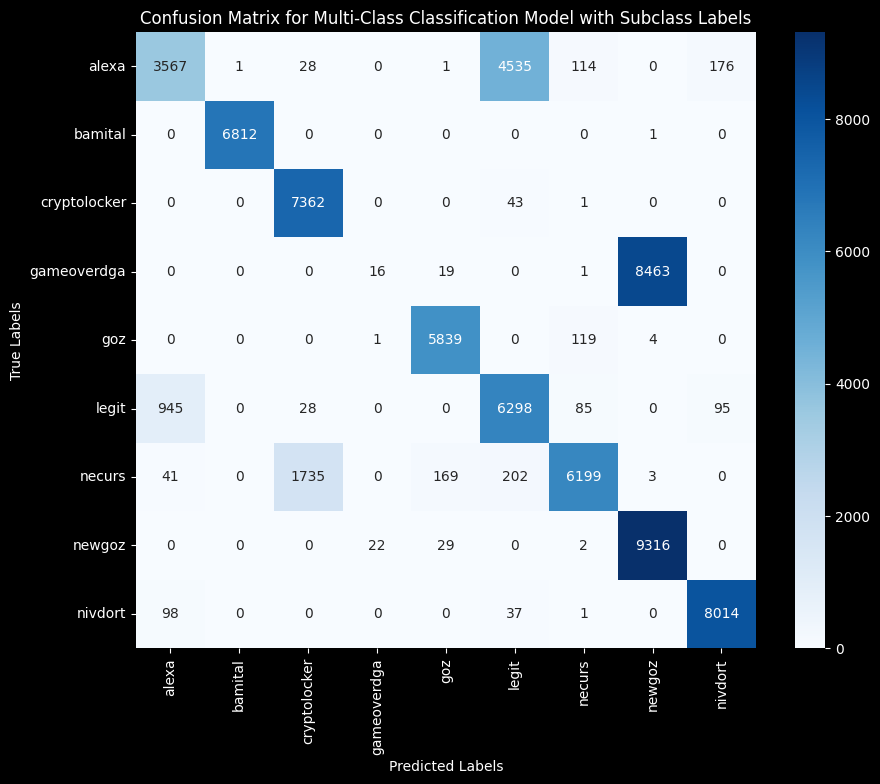

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Convert one-hot encoded labels back to integer format for confusion matrix
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict([X_seq_test, X_feat_test]), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Retrieve the subclass names as labels for the confusion matrix
subclass_labels = sliced_df['subclass'].astype('category').cat.categories

# Plot confusion matrix with subclass names as labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subclass_labels, yticklabels=subclass_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification Model with Subclass Labels')
plt.show()


# Hyperparameter Tuning (Multi-classification)

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Hypermodel function
def build_model(hp):
    # Sequence Input
    input_seq = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32))(input_seq)

    # CNN + LSTM branch
    x = Conv1D(filters=hp.Choice('conv_filters', [32, 64, 128]), kernel_size=5, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = LSTM(hp.Int('lstm_units_1', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = LSTM(hp.Int('lstm_units_2', min_value=32, max_value=64, step=32))(x)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)

    # Engineered Feature Input
    input_features = Input(shape=(X_engineered.shape[1],))
    y = BatchNormalization()(input_features)
    y = Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu')(y)

    # Concatenate RNN and Engineered features
    combined = Concatenate()([x, y])
    z = Dense(hp.Int('dense_units_combined', min_value=32, max_value=128, step=32), activation='relu')(combined)
    z = Dropout(hp.Float('dropout_combined', 0.2, 0.5, step=0.1))(z)
    output = Dense(num_classes, activation='softmax')(z)

    # Compile model
    model = Model(inputs=[input_seq, input_features], outputs=output)
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from keras_tuner import RandomSearch

# Set up the tuner with RandomSearch strategy
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='dga_detection'
)

# Search for the best hyperparameters
tuner.search([X_seq_train, X_feat_train], y_train,
             validation_split=0.2,
             epochs=10,
             batch_size=32,
             verbose=2)

Trial 3 Complete [00h 26m 29s]
val_accuracy: 0.755462646484375

Best val_accuracy So Far: 0.755462646484375
Total elapsed time: 01h 20m 04s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |32                |embedding_dim
32                |128               |conv_filters
64                |96                |lstm_units_1
32                |32                |lstm_units_2
0.4               |0.4               |dropout_rate
32                |32                |dense_units
96                |64                |dense_units_combined
0.4               |0.4               |dropout_combined
0.0001            |0.0001            |learning_rate

Epoch 1/10
7043/7043 - 71s - 10ms/step - accuracy: 0.5486 - loss: 0.9352 - val_accuracy: 0.6492 - val_loss: 0.6892
Epoch 2/10
7043/7043 - 68s - 10ms/step - accuracy: 0.6457 - loss: 0.6996 - val_accuracy: 0.6968 - val_loss: 0.5981
Epoch 3/10
7043/7043 - 82s - 12ms/step - accuracy: 0.6855 - loss: 0.6196 - va

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit([X_seq_train, X_feat_train], y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    verbose=2)

# Adding CNN Layer before RNN (Binary-classification)

In [ ]:
# Convert subclass labels to binary (1 for DGA, 0 for legit/alexa)
sliced_df['binary_label'] = sliced_df['subclass'].apply(lambda x: 0 if x in ['legit', 'alexa'] else 1)

# Extract binary labels for model training
y = sliced_df['binary_label'].values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical  # <-- Add this line
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, BatchNormalization, Conv1D, MaxPooling1D
from sklearn.metrics import confusion_matrix

# Sample Data Preparation
# (Ensure `sliced_df` is loaded with 'domain', 'host', and 'subclass' columns)

# Feature Engineering
def extract_features(domain):
    length = len(domain)
    digit_count = sum(c.isdigit() for c in domain)
    special_char_count = sum(not c.isalnum() for c in domain)
    entropy = -sum((domain.count(c) / length) * np.log2(domain.count(c) / length) for c in set(domain))
    return [length, digit_count, special_char_count, entropy]

# Apply the feature extraction function
sliced_df[['length', 'digit_count', 'special_char_count', 'entropy']] = sliced_df['domain'].apply(
    lambda x: pd.Series(extract_features(x)))

# Update Labels for Binary Classification
sliced_df['binary_label'] = sliced_df['subclass'].apply(lambda x: 0 if x in ['legit', 'alexa'] else 1)
y = sliced_df['binary_label'].values  # Extract binary labels for model training

# Tokenize the 'domain' column for RNN input
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sliced_df['domain'])
X_sequences = tokenizer.texts_to_sequences(sliced_df['domain'])
max_sequence_length = max(len(seq) for seq in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

# Extract feature matrix for engineered features
X_engineered = sliced_df[['length', 'digit_count', 'special_char_count', 'entropy']].values

# Train-Test Split
X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_padded, X_engineered, y, test_size=0.2, random_state=42
)

# RNN branch with CNN before LSTM
input_seq = Input(shape=(max_sequence_length,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_seq)
x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = MaxPooling1D()(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Engineered feature branch
input_features = Input(shape=(X_engineered.shape[1],))
y_input = BatchNormalization()(input_features)
y_input = Dense(32, activation='relu')(y_input)

# Concatenate RNN and engineered features
combined = Concatenate()([x, y_input])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)  # Change to 1 unit with sigmoid for binary classification

# Compile the model
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(
    [X_seq_train, X_feat_train], y_train,
    validation_split=0.2, epochs=10, batch_size=32, verbose=2
)



Epoch 1/10
7043/7043 - 73s - 10ms/step - accuracy: 0.9310 - loss: 0.1517 - val_accuracy: 0.9663 - val_loss: 0.0867
Epoch 2/10
7043/7043 - 80s - 11ms/step - accuracy: 0.9744 - loss: 0.0686 - val_accuracy: 0.9773 - val_loss: 0.0604
Epoch 3/10
7043/7043 - 82s - 12ms/step - accuracy: 0.9809 - loss: 0.0528 - val_accuracy: 0.9821 - val_loss: 0.0552
Epoch 4/10
7043/7043 - 82s - 12ms/step - accuracy: 0.9844 - loss: 0.0440 - val_accuracy: 0.9808 - val_loss: 0.0506
Epoch 5/10
7043/7043 - 82s - 12ms/step - accuracy: 0.9870 - loss: 0.0373 - val_accuracy: 0.9851 - val_loss: 0.0463
Epoch 6/10
7043/7043 - 82s - 12ms/step - accuracy: 0.9886 - loss: 0.0328 - val_accuracy: 0.9861 - val_loss: 0.0407
Epoch 7/10
7043/7043 - 81s - 12ms/step - accuracy: 0.9903 - loss: 0.0280 - val_accuracy: 0.9858 - val_loss: 0.0429
Epoch 8/10
7043/7043 - 67s - 10ms/step - accuracy: 0.9916 - loss: 0.0248 - val_accuracy: 0.9850 - val_loss: 0.0507
Epoch 9/10
7043/7043 - 83s - 12ms/step - accuracy: 0.9926 - loss: 0.0218 - val_a

In [ ]:
# Evaluate and Calculate Specificity
y_pred = (model.predict([X_seq_test, X_feat_test]) > 0.5).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.3f}")

2201/2201 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Specificity (True Negative Rate): 0.962


# Use GRU instead of LSTM

In [ ]:
# RNN using GRU
input_seq = Input(shape=(max_sequence_length,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_seq)
x = GRU(128, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = GRU(64)(x)
x = Dropout(0.3)(x)

# Engineered feature branch
input_features = Input(shape=(X_engineered.shape[1],))
y = BatchNormalization()(input_features)
y = Dense(32, activation='relu')(y)

# Concatenate RNN and engineered features
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(num_classes, activation='softmax')(z)

# Create and compile the model
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    [X_seq_train, X_feat_train], y_train,
    validation_split=0.2, epochs=10, batch_size=32, verbose=2
)

In [ ]:
# Step 4: Evaluate the Model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Using L2 Regulization and Batch Normalization

In [ ]:
# RNN branch with LSTM, BatchNormalization, Dropout, and L2 regularization
input_seq = Input(shape=(max_sequence_length,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_seq)
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Engineered feature branch with BatchNormalization and L2 regularization
input_features = Input(shape=(X_engineered.shape[1],))
y = BatchNormalization()(input_features)
y = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(y)
y = Dropout(0.2)(y)

# Concatenate RNN and engineered features
combined = Concatenate()([x, y])
z = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
z = BatchNormalization()(z)
z = Dropout(0.2)(z)
output = Dense(num_classes, activation='softmax')(z)

# Create and compile the model
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    [X_seq_train, X_feat_train], y_train,
    validation_split=0.2, epochs=10, batch_size=32, verbose=2
)

In [ ]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Implement Early Stopping

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
# Train the Model
# Create and compile the model
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_seq_train, X_feat_train],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")